# Problemin Tanımı:
Doktor ortamında paylaşılan problemden sonra çekilen
filmde doktora ulaşmadan hemen önce x-ray üzerinde kırığın hemen tespit
edilmesi.

# Veri Hakkında:
Veri seti içerisinde 38 adet kırık kol x-ray görüntüleri jpg ve jpeg formatında bulunmaktadır. Veri setine ek olarak yapılan işaretlemelerle birlikte kırık kemiklerin işaretlendiği json dosyaları eklenmiştir.

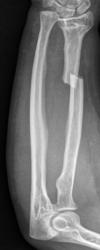
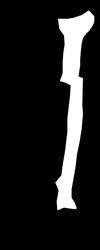
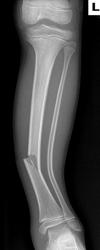
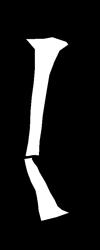
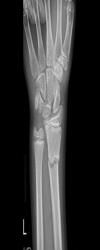
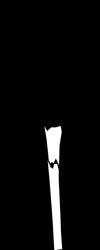

En kötü çıktı:

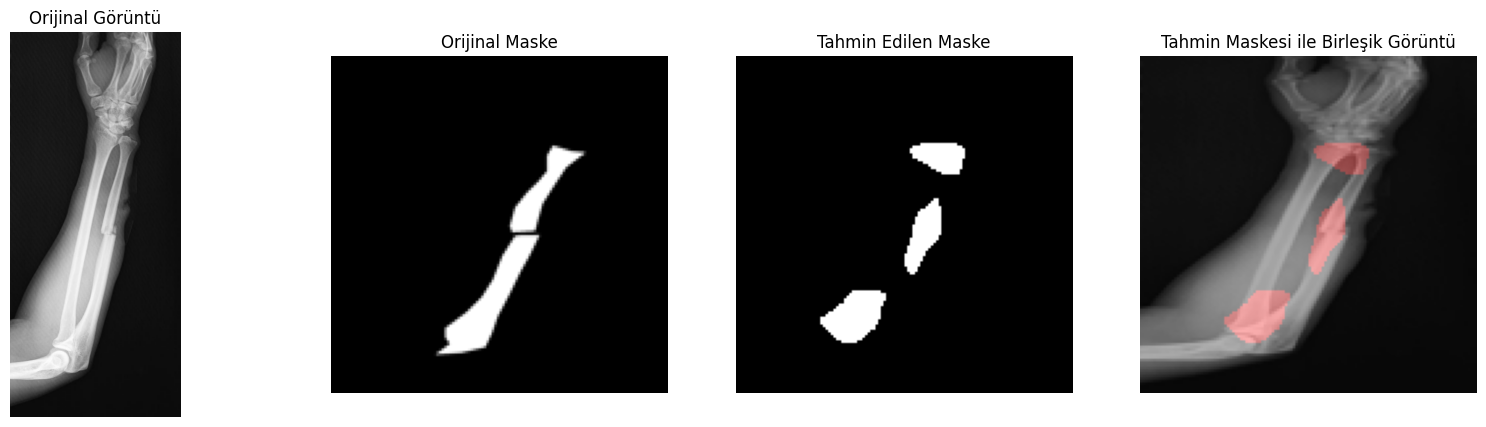

# Çözüm Aşamaları:

Verilerin toplanması.
Elde edilen verilerde kırık olan kemiklerin işaretlenmesi.
Oluşturulan makine öğrenmesi algoritmasının kırık kemik görüntüleri ve oluşturulan maske ile eğitilmesi.
İşaretlenen kemiğin ekseninin belirlenmesi.

Gerekli kütüphanelerin eklenmesi

In [11]:
import os
from glob import glob
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from monai.data import DataLoader
from monai.transforms import Compose, ScaleIntensity
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import torch.nn.functional as F
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.util import view_as_windows

Verilerin eklenmesi

In [12]:
# Verilerin olduğu klasör
tempdir = "DB"
images = sorted(glob(os.path.join(tempdir, "img*.png")))
labels = sorted(glob(os.path.join(tempdir, "label*.png")))

Görüntü işleme fonksiyonu

In [13]:
# Görseli işleyen fonksiyon
def process_image(image_path):
    # Görseli oku (OpenCV ile)
    image = cv2.imread(image_path)  # Görseli oku (OpenCV ile)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Görseli RGB formatına çevir (OpenCV BGR okur)

    # Gamma düzeltme fonksiyonu
    def gamma_correction(image, gamma):
        img_array = np.asarray(image) / 255.0  # Görseli [0,1] aralığına normalize et
        img_array = np.power(img_array, gamma)  # Gamma fonksiyonunu uygula
        img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)  # Görseli tekrar [0,255] aralığına döndür
        return img_array

    # Görseli gamma düzeltmesi ile işleyelim (gamma=2.0)
    img_gamma = gamma_correction(image_rgb, 2.0)

    # Renkli görseli gri tonlamaya çevir
    image_gray = cv2.cvtColor(img_gamma, cv2.COLOR_RGB2GRAY)

    # Pencerelerin boyutu (7x7)
    window_size = (7, 7)

    # Gri görseli küçük pencerelere ayır
    windows = view_as_windows(image_gray, window_size)

    # Standard sapma görseli oluşturmak için boş bir dizi
    std_image = np.zeros_like(image_gray, dtype=np.float32)

    # Her pencere için standard sapma hesapla
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            window = windows[i, j]  # Pencereyi al
            std_value = np.std(window)  # Bu penceredeki standard sapmayı hesapla
            std_image[i, j] = std_value  # Hesaplanan standard sapmayı görsele yaz

    # Standard sapma görselini PIL formatına çevir
    std_image_pil = Image.fromarray(np.uint8(std_image))

    # Parlaklık ayarlama fonksiyonu
    def adjust_brightness(image, factor):
        image_rgb = np.stack([image] * 3, axis=-1)  # Görseli 3 kanallı yap (RGB)
        hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)  # Görseli HSV renk uzayına çevir
        hsv = np.array(hsv, dtype=np.float64)  # HSV değerlerini float64 tipine çevir
        hsv[:,:,2] = np.clip(hsv[:,:,2] * factor, 0, 255)  # Parlaklık kanalını faktörle çarp ve sınırla
        return cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2RGB)  # Görseli tekrar RGB'ye çevir

    # Parlaklık artırma işlemi uygula
    img_bright = adjust_brightness(std_image_pil, 15)

    # Parlaklık eşikleme fonksiyonu
    def threshold_brightness(image, threshold):
        image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Görseli gri tonlamaya çevir
        _, thresholded_image = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_TOZERO)  # Eşikleme uygula
        return cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2RGB)  # Sonucu tekrar RGB'ye çevir

    # Eşikleme işlemi uygula (parlaklık 75'ın üstündeki pikselleri tut)
    img_bright_thresholded = threshold_brightness(img_bright, 75)

    # Görseli medyan bulanıklaştırma işlemi uygula
    img_bright_thresholded_blurred = cv2.medianBlur(img_bright_thresholded, 5)

    # Min-max normalizasyonu ile görseli yeniden ölçeklendir
    min_max_norm = cv2.normalize(img_bright_thresholded_blurred, None, 0, 255, cv2.NORM_MINMAX)

    return image_rgb, img_gamma, std_image, img_bright, img_bright_thresholded, img_bright_thresholded_blurred, min_max_norm

# Padding işlevi
def pad_to_match_model(tensor, factor=16):
    """
    Görüntü boyutunu modelin gereksinimlerine göre uygun bir şekilde pad eder.
    tensor: 3 boyutlu (channel, height, width) veya 4 boyutlu (batch_size, channels, height, width) olabilir.
    """
    if len(tensor.shape) == 3:
        tensor = tensor.unsqueeze(0)  # (C, H, W) -> (1, C, H, W)
    
    _, _, h, w = tensor.size()
    pad_h = (factor - h % factor) % factor
    pad_w = (factor - w % factor) % factor

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom))
    
    if len(tensor.shape) == 4:
        return padded_tensor
    else:
        return padded_tensor.squeeze(0)  # (1, C, H, W) -> (C, H, W) geri döndür

Görselleri küçük parçalara ayırma

In [14]:
# Görseli küçük parçalara bölen fonksiyon
def split_image_into_patches(image, patch_size=128):
    """
    Görseli belirli bir boyutla parçalara böler.
    image: NumPy array formatındaki giriş görüntüsü (2D).
    patch_size: Parçaların boyutu.
    """
    patches = []
    h, w = image.shape  # Görüntü yalnızca 2 boyutlu (yükseklik, genişlik)
    
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i:i + patch_size, j:j + patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    return patches

Eğitim ve Test verisi ayrıştırma ve verilerin yüklenmesi

In [15]:
# Veri bölme (80% eğitim, 20% test)
data_size = len(images)
indices = np.arange(data_size)
np.random.seed(42)
np.random.shuffle(indices)

split_idx = int(data_size * 0.8)
train_indices, test_indices = indices[:split_idx], indices[split_idx:]
train_images = [images[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]
test_images = [images[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]

# Dataset ve DataLoader
class ProcessedPatchDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, label_paths, transform=None, patch_size=128):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Görüntü ve etiketleri yükle
        image = Image.open(self.image_paths[idx]).convert('L')  # Grayscale olarak yükle
        label = Image.open(self.label_paths[idx]).convert('L')  # Grayscale olarak yükle

        # Görüntüleri numpy array'e dönüştür
        image = np.array(image)
        label = np.array(label)

        # Dönüşüm varsa uygula
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Görüntü ve etiketleri küçük parçalara ayır
        image_patches = split_image_into_patches(image, self.patch_size)
        label_patches = split_image_into_patches(label, self.patch_size)

        # Her parça için bir çift döndür
        patches = [(img, lbl) for img, lbl in zip(image_patches, label_patches)]
        return patches

# Eğitim ve test dönüşümleri
train_imtrans = Compose([ScaleIntensity(), lambda x: torch.tensor(x, dtype=torch.float32)])
test_imtrans = Compose([ScaleIntensity(), lambda x: torch.tensor(x, dtype=torch.float32)])

# Dataset ve DataLoader
train_ds = ProcessedPatchDataset(train_images, train_labels, transform=train_imtrans, patch_size=128)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)

test_ds = ProcessedPatchDataset(test_images, test_labels, transform=test_imtrans, patch_size=128)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

Modelin tanımlanması ve eğitilmesi

In [16]:
# Model ve eğitim yapılandırması
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Eğitim döngüsü
writer = SummaryWriter()
epoch_loss_values = []
for epoch in range(5):
    model.train()
    epoch_loss = 0
    for batch_data in train_loader:
        for inputs, labels in batch_data:  # Her bir parça için eğitim
            inputs, labels = inputs.to(device), labels.to(device)

            # GPU belleği temizleme
            torch.cuda.empty_cache()

            inputs = pad_to_match_model(inputs)
            labels = pad_to_match_model(labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
    writer.add_scalar("train_loss", epoch_loss, epoch)

torch.save(model.state_dict(), "model.pth")

/tmp/ipykernel_7098/2972980062.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imtrans = Compose([ScaleIntensity(), lambda x: torch.tensor(x, dtype=torch.float32)])


Epoch 1, Loss: 54.5555
Epoch 2, Loss: 53.0792
Epoch 3, Loss: 52.5119
Epoch 4, Loss: 52.3556
Epoch 5, Loss: 52.1948


Modelin model.pth ismi ile kaydedilmesi

In [17]:
torch.save(model.state_dict(), "model.pth")

Görüntü işleme uygulanmış tahmin

/tmp/ipykernel_15292/2640254707.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))
/tmp/ipykernel_15292/2640254707.py:144: U

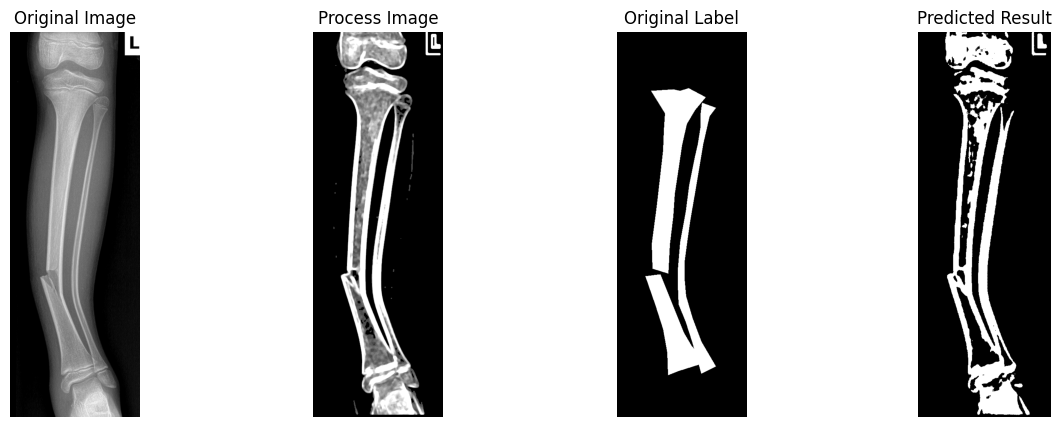

In [2]:
import os
from glob import glob
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from monai.data import DataLoader
from monai.transforms import Compose, ScaleIntensity
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import torch.nn.functional as F
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.util import view_as_windows


# Padding işlevi
def pad_to_match_model(tensor, factor=16):
    """
    Görüntü boyutunu modelin gereksinimlerine göre uygun bir şekilde pad eder.
    tensor: 3 boyutlu (channel, height, width) veya 4 boyutlu (batch_size, channels, height, width) olabilir.
    """
    if len(tensor.shape) == 3:
        tensor = tensor.unsqueeze(0)  # (C, H, W) -> (1, C, H, W)
    
    _, _, h, w = tensor.size()
    pad_h = (factor - h % factor) % factor
    pad_w = (factor - w % factor) % factor

    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    padded_tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom))
    
    if len(tensor.shape) == 4:
        return padded_tensor
    else:
        return padded_tensor.squeeze(0)  # (1, C, H, W) -> (C, H, W) geri döndür

# Modeli yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("model.pth"))
model.eval()  # Değerlendirme moduna geç

# Görseli ve etiketini yükle
img_path = "DB/img2.png"
label_path = "DB/label2.png"

image = Image.open(img_path).convert("L")  # Grayscale olarak yükle
label = Image.open(label_path).convert("L")

# Gamma düzeltme fonksiyonu
def gamma_correction(image, gamma):
    img_array = np.asarray(image) / 255.0  # Görseli [0,1] aralığına normalize et
    img_array = np.power(img_array, gamma)  # Gamma fonksiyonunu uygula
    img_array = np.clip(img_array * 255, 0, 255).astype(np.uint8)  # Görseli tekrar [0,255] aralığına döndür
    return img_array

# Görseli gamma düzeltmesi ile işleyelim (gamma=2.0)
img_gamma = gamma_correction(image, 2.0)

# Pencerelerin boyutu (7x7)
window_size = (7, 7)

# Gri görseli küçük pencerelere ayır
windows = view_as_windows(img_gamma, window_size)

# Standard sapma görseli oluşturmak için boş bir dizi
std_image = np.zeros_like(img_gamma, dtype=np.float32)

# Her pencere için standard sapma hesapla
for i in range(windows.shape[0]):
    for j in range(windows.shape[1]):
        window = windows[i, j]  # Pencereyi al
        std_value = np.std(window)  # Bu penceredeki standard sapmayı hesapla
        std_image[i, j] = std_value  # Hesaplanan standard sapmayı görsele yaz

# Standard sapma görselini PIL formatına çevir
std_image_pil = Image.fromarray(np.uint8(std_image))

# Parlaklık ayarlama fonksiyonu
def adjust_brightness(image, factor):
    image_rgb = np.stack([image] * 3, axis=-1)  # Görseli 3 kanallı yap (RGB)
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)  # Görseli HSV renk uzayına çevir
    hsv = np.array(hsv, dtype=np.float64)  # HSV değerlerini float64 tipine çevir
    hsv[:,:,2] = np.clip(hsv[:,:,2] * factor, 0, 255)  # Parlaklık kanalını faktörle çarp ve sınırla
    return cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2RGB)  # Görseli tekrar RGB'ye çevir

# Görseli standard sapma işlemi sonrası parlaklık artırma işlemi uygula
std_image_np = np.array(std_image_pil)  # PIL Image'den numpy dizisine çevir
img_bright_np = adjust_brightness(std_image_np, 15)  # Parlaklığı artır (örneğin factor 1.5)

# Numpy dizisini tekrar PIL formatına çevir
img_bright = Image.fromarray(img_bright_np)

# Parlaklık eşikleme fonksiyonu
def threshold_brightness(image, threshold):
    # PIL Image'den NumPy array'e dönüştür
    image_np = np.array(image)
    
    # Görseli gri tonlamaya çevir
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    # Eşikleme uygula
    _, thresholded_image = cv2.threshold(image_gray, threshold, 255, cv2.THRESH_TOZERO)
    
    # Sonucu tekrar RGB'ye çevir
    return cv2.cvtColor(thresholded_image, cv2.COLOR_GRAY2RGB)

# Eşikleme işlemi uygula (parlaklık 90'ın üstündeki pikselleri tut)
img_bright_thresholded = threshold_brightness(img_bright, 70)

# Görseli medyan bulanıklaştırma işlemi uygula
img_bright_thresholded_blurred = cv2.medianBlur(img_bright_thresholded, 5)

# Min-max normalizasyonu ile görseli yeniden ölçeklendir
min_max_norm = cv2.normalize(img_bright_thresholded_blurred, None, 0, 255, cv2.NORM_MINMAX)

# NumPy array'ini tekrar PIL Image formatına çevir
min_max_norm_pil = Image.fromarray(min_max_norm)

# Eğer görseli grayscale (L mode) olarak saklamak istiyorsanız, şu şekilde dönüştürebilirsiniz:
min_max_norm_pil = min_max_norm_pil.convert("L")

# Final görseli
img = min_max_norm_pil


# Görselleştirme için işleme
transform = Compose([
    ScaleIntensity(),  # Yoğunluğu normalleştir
    lambda x: torch.tensor(x, dtype=torch.float32)  # NumPy array'ini Tensor'a çevir
])

# Görseli ve etiketini işleme
img_tensor = transform(np.array(img)).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
label_tensor = transform(np.array(label)).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

# Görsel boyutlarını eşitleme (pad işlemi)
img_tensor = pad_to_match_model(img_tensor)
label_tensor = pad_to_match_model(label_tensor)

# Tahmin yap
with torch.no_grad():
    output = model(img_tensor)

# Tahmin edilen sonucun sigmoid fonksiyonu ile işlenmesi
output = torch.sigmoid(output)

# Çıktıyı numpy array'ine çevir ve threshold ile ikili hale getir
output_np = output.squeeze().cpu().numpy()
output_np = (output_np > 0.5).astype(np.uint8)  # 0.5'lik threshold ile ikili görüntü elde et

# Orijinal görsel, etiket ve tahmin edilen sonuçları görselleştir
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Orijinal Görsel
axs[0].imshow(np.array(image), cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

# İşlenmiş Görsel
axs[1].imshow(np.array(img), cmap="gray")
axs[1].set_title("Process Image")
axs[1].axis("off")

# Etiket Görseli
axs[2].imshow(np.array(label), cmap="gray")
axs[2].set_title("Original Label")
axs[2].axis("off")

# Tahmin Edilen Sonuç
axs[3].imshow(output_np, cmap="gray")
axs[3].set_title("Predicted Result")
axs[3].axis("off")

plt.show()


Görüntü işleme olmadan yapılan tahmin

/tmp/ipykernel_7098/3842767560.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))
/tmp/ipykernel_7098/3842767560.py:41: User

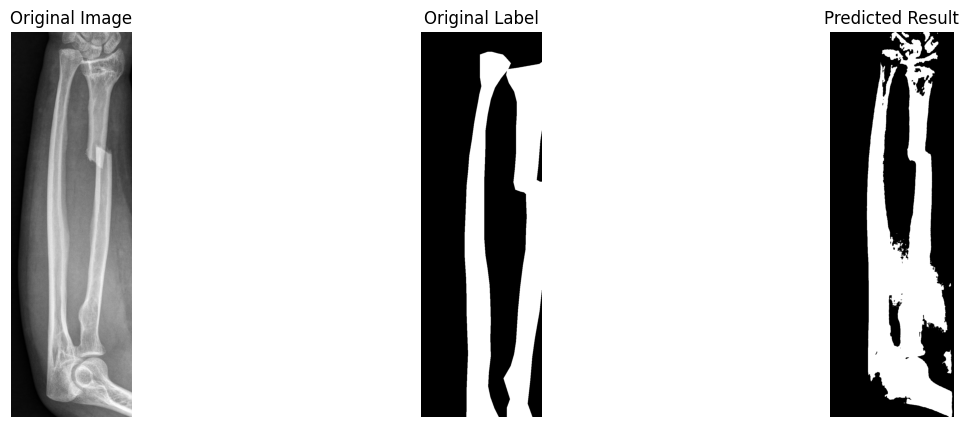

In [20]:
import os
from glob import glob
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from monai.data import DataLoader
from monai.transforms import Compose, ScaleIntensity
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.losses import DiceLoss
import torch.nn.functional as F
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from skimage.util import view_as_windows

# Modeli yükle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

model.load_state_dict(torch.load("model.pth"))
model.eval()  # Değerlendirme moduna geç

# Görseli ve etiketini yükle
img_path = "DB/img1.png"
label_path = "DB/label1.png"

img = Image.open(img_path).convert("L")  # Grayscale olarak yükle
label = Image.open(label_path).convert("L")

# Görselleştirme için işleme
transform = Compose([
    ScaleIntensity(),  # Yoğunluğu normalleştir
    lambda x: torch.tensor(x, dtype=torch.float32)  # NumPy array'ini Tensor'a çevir
])

# Görseli ve etiketini işleme
img_tensor = transform(np.array(img)).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)
label_tensor = transform(np.array(label)).unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, H, W)

# Görsel boyutlarını eşitleme (pad işlemi)
img_tensor = pad_to_match_model(img_tensor)
label_tensor = pad_to_match_model(label_tensor)

# Tahmin yap
with torch.no_grad():
    output = model(img_tensor)

# Tahmin edilen sonucun sigmoid fonksiyonu ile işlenmesi
output = torch.sigmoid(output)

# Çıktıyı numpy array'ine çevir ve threshold ile ikili hale getir
output_np = output.squeeze().cpu().numpy()
output_np = (output_np > 0.5).astype(np.uint8)  # 0.5'lik threshold ile ikili görüntü elde et

# Orijinal görsel, etiket ve tahmin edilen sonuçları görselleştir
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Orijinal Görsel
axs[0].imshow(np.array(img), cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

# Etiket Görseli
axs[1].imshow(np.array(label), cmap="gray")
axs[1].set_title("Original Label")
axs[1].axis("off")

# Tahmin Edilen Sonuç
axs[2].imshow(output_np, cmap="gray")
axs[2].set_title("Predicted Result")
axs[2].axis("off")

plt.show()


/tmp/ipykernel_15292/2640254707.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lambda x: torch.tensor(x, dtype=torch.float32)  # NumPy array'ini Tensor'a çevir


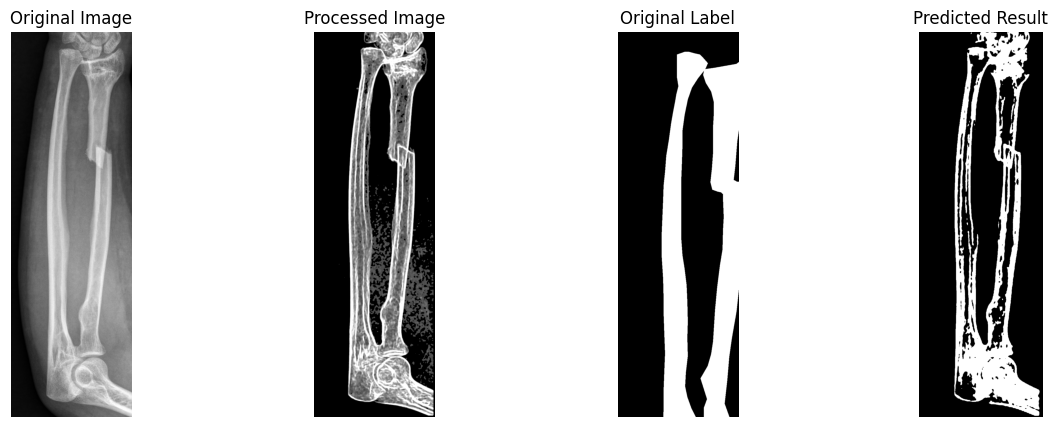

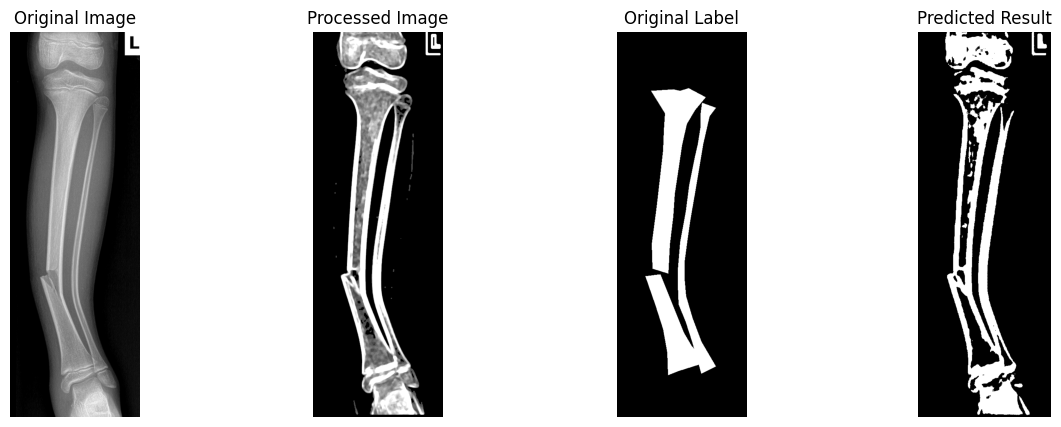

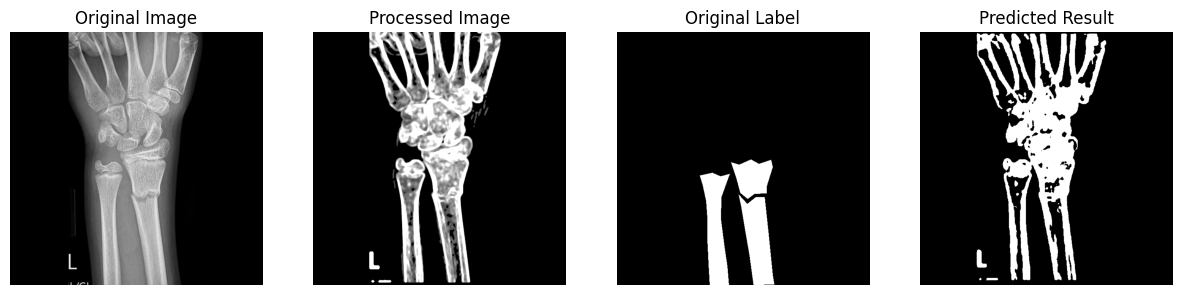

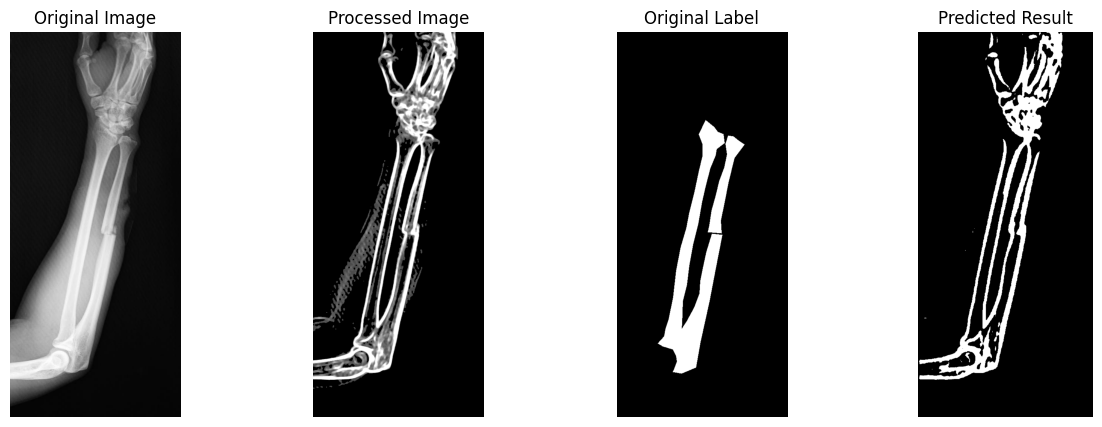

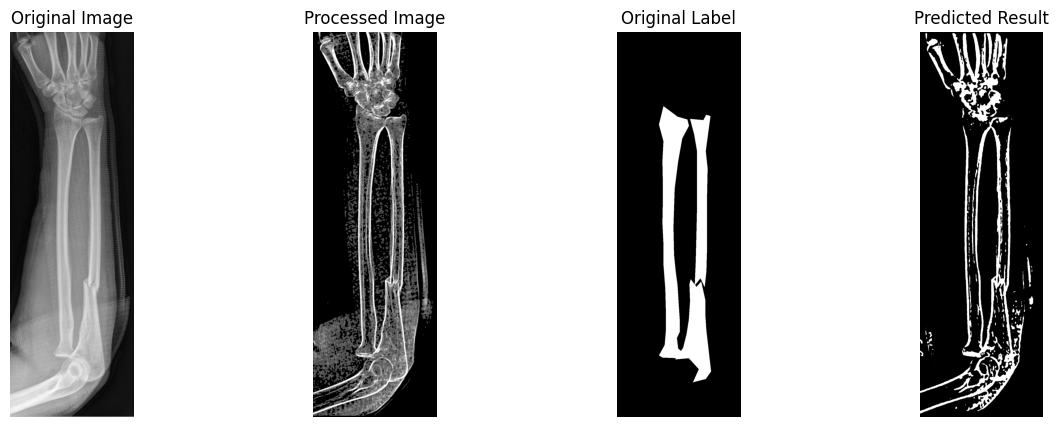

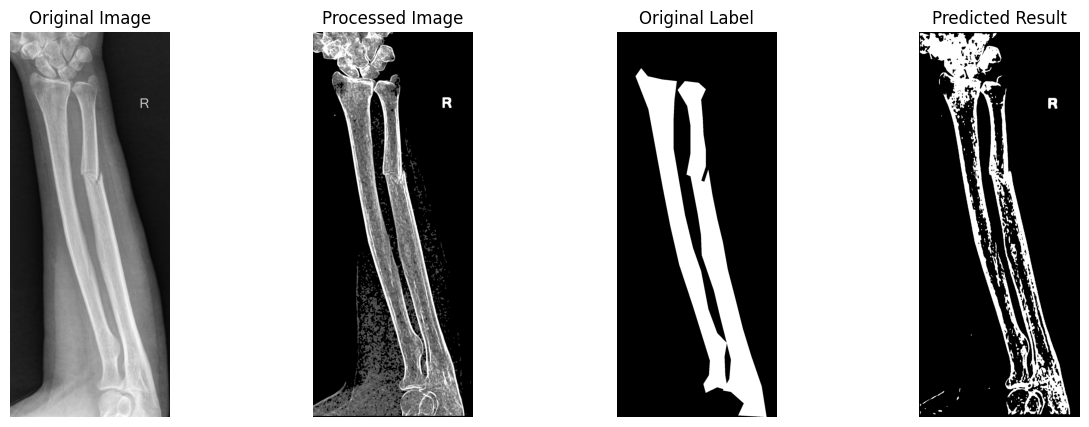

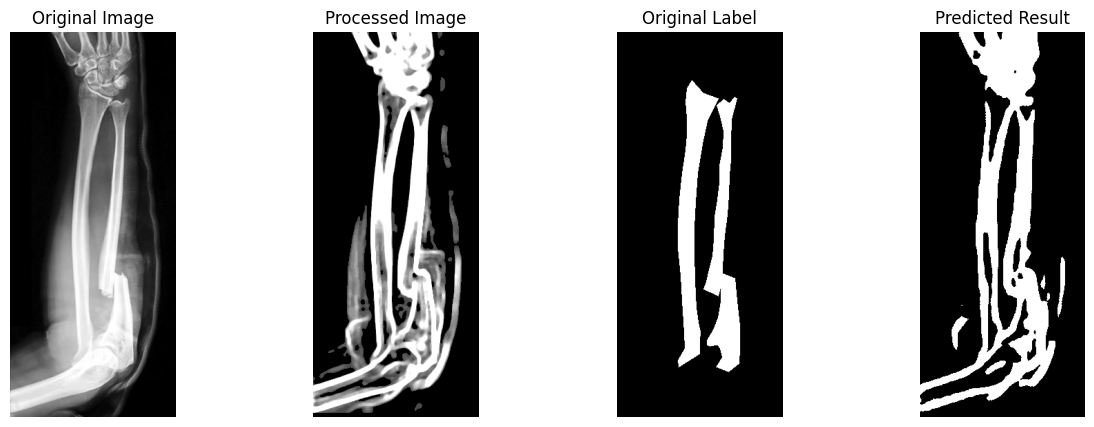

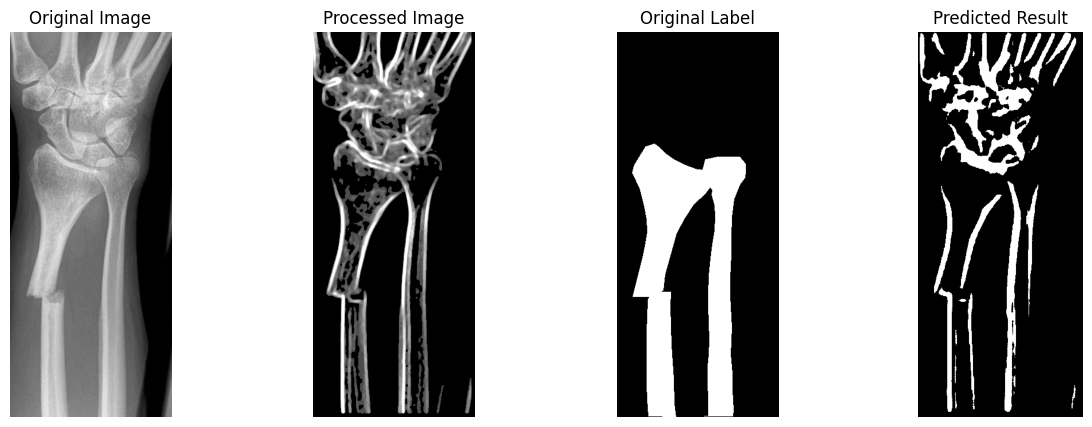

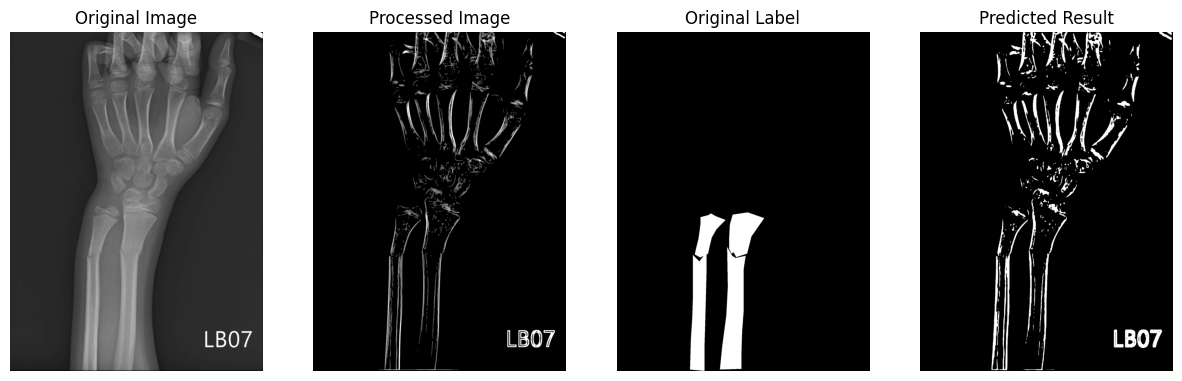

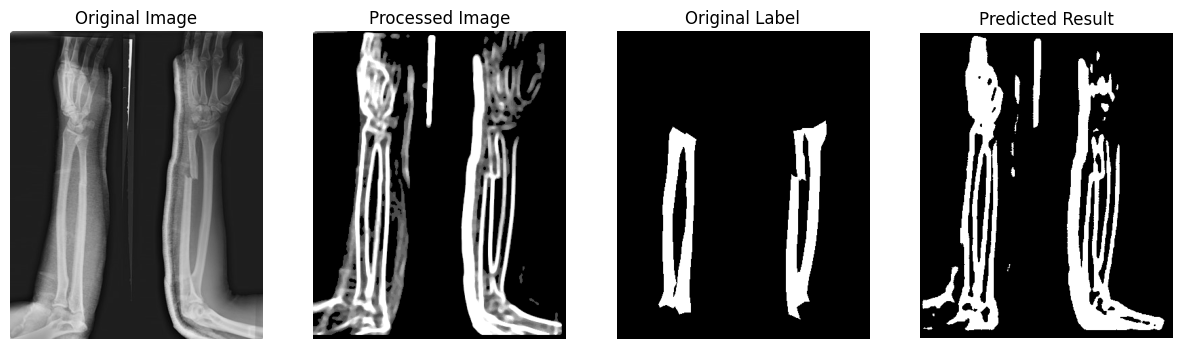

Tahminler tamamlandı ve kaydedildi.


In [3]:
# Tahminler için 10 farklı görseli işleyelim
for i in range(1, 11):  # 1'den 10'a kadar döngü
    img_path = f"DB/img{i}.png"
    label_path = f"DB/label{i}.png"

    image = Image.open(img_path).convert("L")  # Grayscale olarak yükle
    label = Image.open(label_path).convert("L")

    # Gamma düzeltme ve diğer işlemleri tekrar uygula
    img_gamma = gamma_correction(image, 2.0)

    # Gri görseli küçük pencerelere ayır
    windows = view_as_windows(img_gamma, window_size)

    # Standard sapma görselini oluştur
    std_image = np.zeros_like(img_gamma, dtype=np.float32)
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            window = windows[i, j]  # Pencereyi al
            std_value = np.std(window)  # Bu penceredeki standard sapmayı hesapla
            std_image[i, j] = std_value  # Hesaplanan standard sapmayı görsele yaz

    # Standard sapma görselini PIL formatına çevir
    std_image_pil = Image.fromarray(np.uint8(std_image))

    # Parlaklık ayarlama ve diğer işlemleri tekrar uygula
    std_image_np = np.array(std_image_pil)  # PIL Image'den numpy dizisine çevir
    img_bright_np = adjust_brightness(std_image_np, 15)  # Parlaklık artır
    img_bright = Image.fromarray(img_bright_np)

    # Eşikleme işlemi ve sonrasındaki işlemleri tekrar uygula
    img_bright_thresholded = threshold_brightness(img_bright, 70)
    img_bright_thresholded_blurred = cv2.medianBlur(img_bright_thresholded, 5)
    min_max_norm = cv2.normalize(img_bright_thresholded_blurred, None, 0, 255, cv2.NORM_MINMAX)
    min_max_norm_pil = Image.fromarray(min_max_norm)
    min_max_norm_pil = min_max_norm_pil.convert("L")

    # İşleme ve tahmin için hazırlık
    img_tensor = transform(np.array(min_max_norm_pil)).unsqueeze(0).unsqueeze(0).to(device)
    label_tensor = transform(np.array(label)).unsqueeze(0).unsqueeze(0).to(device)

    img_tensor = pad_to_match_model(img_tensor)
    label_tensor = pad_to_match_model(label_tensor)

    # Tahmin yap
    with torch.no_grad():
        output = model(img_tensor)

    output = torch.sigmoid(output)

    # Çıktıyı numpy array'ine çevir ve threshold ile ikili hale getir
    output_np = output.squeeze().cpu().numpy()
    output_np = (output_np > 0.5).astype(np.uint8)

    # Tahmin edilen sonucu kaydet
    output_img = Image.fromarray(output_np * 255)  # 0-1 aralığını 0-255'e çevirerek kaydet
    output_img.save(f"predicted_output_{i}.png")

    # Orijinal, işlenmiş ve tahmin edilen görselleri görselleştir
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Orijinal Görsel
    axs[0].imshow(np.array(image), cmap="gray")
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    # İşlenmiş Görsel
    axs[1].imshow(np.array(min_max_norm_pil), cmap="gray")
    axs[1].set_title("Processed Image")
    axs[1].axis("off")

    # Etiket Görseli
    axs[2].imshow(np.array(label), cmap="gray")
    axs[2].set_title("Original Label")
    axs[2].axis("off")

    # Tahmin Edilen Sonuç
    axs[3].imshow(output_np, cmap="gray")
    axs[3].set_title("Predicted Result")
    axs[3].axis("off")

    plt.show()

print("Tahminler tamamlandı ve kaydedildi.")
